In [1]:
prefix = '/home/ines/repositories/'
# prefix = '/Users/ineslaranjeira/Documents/Reposiktories/'

In [2]:

""" 
IMPORTS
"""
import os
import numpy as np
import pickle
import pandas as pd
from one.api import ONE
import numpy as np
import matplotlib.pyplot as plt

# Get my functions
from functions import idxs_from_files, state_identifiability, align_bin_design_matrix, states_per_trial_phase, broader_label
from functions import define_trial_types, rescale_sequence, plot_binned_sequence

one = ONE(mode='remote')

# Parameters

In [3]:
# LOAD DATA
data_path = prefix + 'representation_learning_variability/paper-individuality/data/design_matrices/'
wavelet_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_wavelets/'

all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices)

""" FITTING PARAMETERS """
num_iters = 100
num_states = 2
num_train_batches = 5
method='prior'
fit_method='em'
optimal_k = 5
threshold = 0

whisker_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+'True/'
licking_params = str(num_train_batches)+'_'+method+'_'+fit_method+'_zsc_'+'False/'

states_path = prefix + 'representation_learning_variability/paper-individuality/data/hmm/most_likely_states/'
wavelet_states_path = prefix + 'representation_learning_variability/paper-individuality/data/paw_most_likely_states/'

var_interest_map = ['paw', 'whisker', 'lick']
path_sets = [wavelet_states_path, states_path + whisker_params, states_path+licking_params]

# Individual sessions

In [4]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path + whisker_params, 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path + licking_params, 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id+'.npy')

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 218 sessions to process.


In [5]:
if optimal_k == 8:
    identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '400': 4.0,
           '500': 5.0,
           '600': 6.0,
           '700': 7.0,
           
           '010': 8.0,
           '110': 9.0,
           '210': 10.0,
           '310': 11.0,
           '410': 12.0,
           '510': 13.0,
           '610': 14.0,
           '710': 15.0,

           '001': 16.0,
           '101': 17.0,
           '201': 18.0,
           '301': 19.0, 
           '401': 20.0, 
           '501': 21.0, 
           '601': 22.0, 
           '701': 23.0, 

           '011': 24.0,
           '111': 25.0,
           '211': 26.0,
           '311': 27.0,
           '411': 28.0,
           '511': 29.0,
           '611': 30.0,
           '711': 31.0,
           'nan': np.nan
           }
    # paw_mapping = {0:4, 1:1, 2:5, 3:7, 4:6, 5:2, 6:0, 7:3}
    paw_mapping = {0:1, 1:5, 2:3, 3:0, 4:6, 5:4, 6:7, 7:2}  # original

elif optimal_k == 5:
    identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '400': 4.0,
           
           '010': 5.0,
           '110': 6.0,
           '210': 7.0,
           '310': 8.0,
           '410': 9.0,

           '001': 10.0,
           '101': 11.0,
           '201': 12.0,
           '301': 13.0, 
           '401': 14.0, 

           '011': 15.0,
           '111': 16.0,
           '211': 17.0,
           '311': 18.0,
           '411': 19.0,
           'nan': np.nan
           }
    paw_mapping = {0:1, 1:2, 2:4, 3:0, 4:3} 
inverted_mapping = {v: k for k, v in identifiable_mapping.items()}

In [6]:
def wheel_over_wavelet_clusters(init, inter, empirical_data, session_trials, color_states):
    # Plot raw trace over states
    # init should be in seconds; inter should be in frames
    frame_rate = 60
    plot_min = -10
    plot_max = 10

    fig, ax = plt.subplots(ncols=1 , nrows=1, sharex=False, sharey=False, figsize=[20, 5])
    plt.rc('font', size=12)

    # ax.plot(data)
    ax.plot(empirical_data.loc[empirical_data['Bin']>=init, 'avg_wheel_vel'].reset_index(), color='black')
    ax.imshow(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, color_states]])[None,:],
                extent=(0, len(np.concatenate([empirical_data.loc[empirical_data['Bin']>=init, color_states]])), -10, 10),
                aspect="auto",
                cmap='Set1',
                alpha=0.6)

    for state, marker in zip([0.,1.], ['','x']):
        mask_whisker = empirical_data.loc[empirical_data['Bin']>=init, 'whisker_states'] == state
        masked_time_whisker = (empirical_data.loc[empirical_data['Bin']>=init, 'Bin'][mask_whisker].reset_index()['Bin']* frame_rate)-init*frame_rate
        mask_lick = empirical_data.loc[empirical_data['Bin']>=init, 'lick_states'] == state
        masked_time_lick = (empirical_data.loc[empirical_data['Bin']>=init, 'Bin'][mask_lick].reset_index()['Bin']* frame_rate)-init*frame_rate
        ax.scatter(masked_time_whisker, np.zeros(np.sum(mask_whisker))+2, marker=marker, c='purple', s=20, alpha=.6)
        ax.scatter(masked_time_lick, np.zeros(np.sum(mask_lick))+3, marker=marker, c='blue', s=20, alpha=.6)
    

    ax.vlines(np.array(session_trials['goCueTrigger_times'] -init)*frame_rate, plot_min, plot_max, label='Stim On', 
                color='Black', linewidth=2)
    ax.vlines(np.array(session_trials.loc[session_trials['feedbackType']==1, 'feedback_times'] * frame_rate)-init*frame_rate, 
                plot_min, plot_max, label='Correct', color='Green', linewidth=2)
    ax.vlines(np.array(session_trials.loc[session_trials['feedbackType']==-1, 'feedback_times'] * frame_rate)-init*frame_rate, 
                plot_min, plot_max, label='Incorrect', color='Red', linewidth=2)
    ax.vlines(np.array(session_trials['firstMovement_times'] * frame_rate)-init*frame_rate, plot_min, plot_max, label='First movement', color='Blue')
    ax.vlines(np.array(session_trials['intervals_0'] * frame_rate)-init*frame_rate, plot_min, plot_max, label='Trial end', color='Grey', linewidth=2)
    ax.vlines(np.array((session_trials['goCueTrigger_times'] - session_trials['quiescencePeriod']) * frame_rate)-init*frame_rate, 
                plot_min, plot_max, label='Quiescence start', color='Pink', linewidth=2)

    ax.set_xlim([init, init+inter])
    ax.set_ylabel("Wheel velocity")
    ax.set_xlabel("Time (s)")
    ax.set_xticks(np.arange(0, inter, inter/5),np.arange(init, 
                                                          (init+inter)/frame_rate, (inter/frame_rate)/5))
    ax.set_title("Wavelet transform clusters")
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    ax.set_ylim([-10, 10])

    plt.tight_layout()    
    plt.show()

/tmp/ipykernel_31857/2648415950.py:34: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  design_matrix[column_name].loc[not_nan_indices] = most_likely_states # [:last_clean_index]
/tmp/ipykernel_31857/2648415950.py:34: SettingWithCopyWarning: 
A

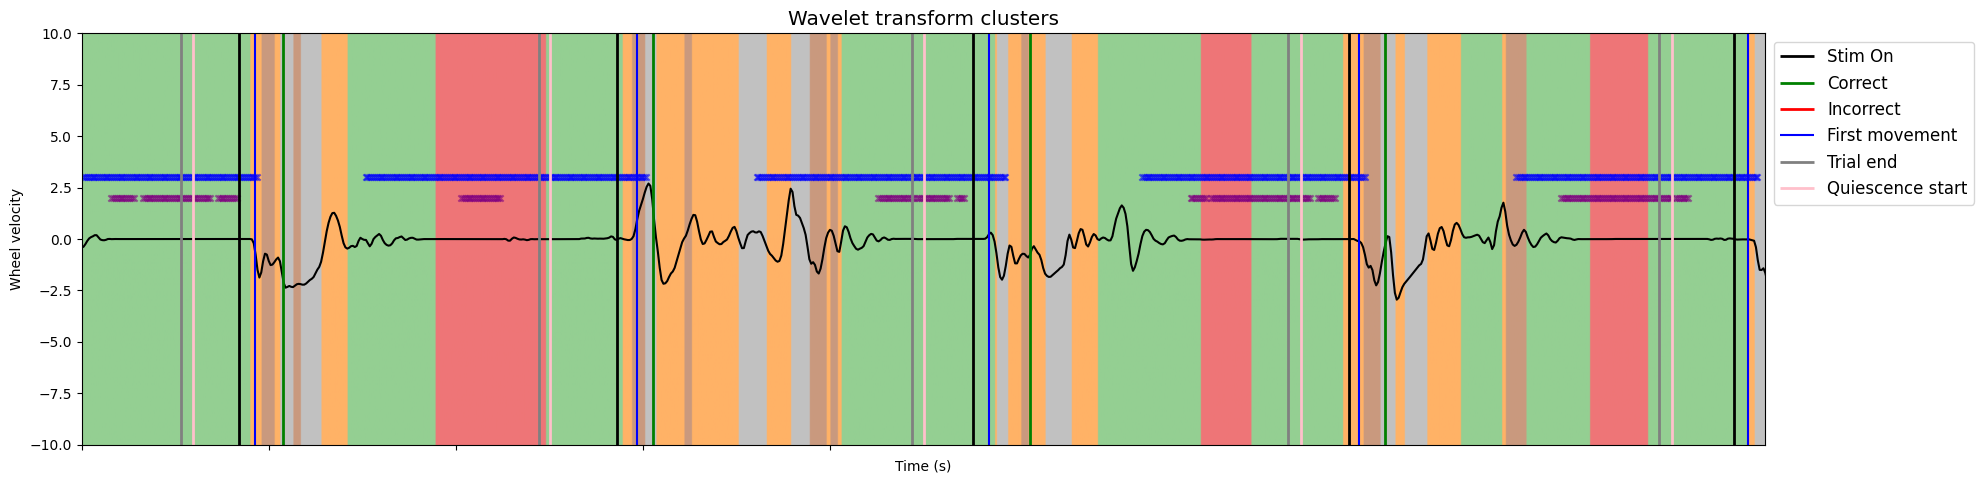

88224abb-5746-431f-9c17-17d7ef806e6a


/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:217: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:245: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Pre-quiescence' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  use_data.loc[(use_data['Bin'] <= pre_qui_end[t]*multiplier) &
/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:50: FutureWarning: Chain

In [11]:
var_interest = ['paw', 'whisker_me', 'Lick count']
states_trial_type = pd.DataFrame(columns=['mouse_name', 'session', 'correct', 'choice', 'contrast', 
                                          'reaction', 'response', 'elongation', 'most_likely_states', 
                                          'identifiable_states', 'Bin', 'label'])
for m, mat in enumerate(sessions_to_process[:1]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    trials_file = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(trials_file, engine='pyarrow').reset_index() 
    filename = wavelet_path + "paw_vel_wavelets_" + str(session) + '_'  + mouse_name
    design_matrix = pd.read_parquet(filename)

    # Prepare data
    num_timesteps = np.shape(design_matrix.dropna())[0]
    hmm_length = (num_timesteps // num_train_batches) * num_train_batches
    not_nan_indices = ~np.isnan(np.array(design_matrix)).any(axis=1)

    # Get states per variable and concatenate
    c_states = []
    for v, var in enumerate(var_interest_map):
        use_path = path_sets[v]
        var_name = var_interest[v]
        states_filename = os.path.join(use_path, 
                                       f"{'most_likely_states_'+str(optimal_k)+ '_' + fit_id + '.npy' if var_name=='paw' else var_name+ '_' + fit_id}")
        column_name = var + '_states'
        design_matrix[column_name] = design_matrix['Bin'] * np.nan
        if var == 'paw':
            most_likely_states = np.load(open(states_filename, "rb"))
            # Rename states to be more intuitive
            replace_func = np.vectorize(paw_mapping.get)
            most_likely_states = replace_func(most_likely_states)
            design_matrix[column_name].loc[not_nan_indices] = most_likely_states # [:last_clean_index]
        else:
            most_likely_states, _, _ = pickle.load(open(states_filename, "rb"))
            dif = np.sum(not_nan_indices)-len(most_likely_states)
            appended = np.concatenate((most_likely_states, [np.nan]*dif))
            design_matrix[column_name].loc[not_nan_indices] = appended
        # Save
        if len(c_states) == 0:
            c_states = most_likely_states[:hmm_length]
        else:
            c_states = np.vstack((c_states, most_likely_states[:hmm_length]))    
     
    combined_states = np.array([''.join(map(str, row)) for row in c_states.T])  
    
    # Transform states into identifiable states
    sets_to_identify = [[], ['whisker_me'], ['Lick count']]
    identifiable_states = state_identifiability(combined_states, design_matrix.loc[not_nan_indices][:hmm_length], sets_to_identify)
    
    replace_func = np.vectorize(identifiable_mapping.get)
    new_states = replace_func(identifiable_states)
    # inverted_mapping = {v: k for k, v in identifiable_mapping.items()}

    # Align bins
    multiplier = 1
    event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
    event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix.loc[not_nan_indices][:hmm_length], new_states, multiplier)
    empirical_data = empirical_data.drop(columns=['new_bin'])
    empirical_data['identifiable_states'] = identifiable_states

    # Plot raw trace over states       
    init = 400
    inter = 500
    use_states = 'paw_states'
    wheel_over_wavelet_clusters(init, inter, empirical_data, session_trials, use_states)
    print(session)
    
    """ Trial types """
    # Split in Foundtrial types
    states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
    states_trial['mouse_name'] = mouse_name
    states_trial['session'] = session
    # replace_func = np.vectorize(inverted_mapping.get)
    # str_states = replace_func(np.array(states_trial['most_likely_states']))
    # states_trial['identifiable_states'] = str_states
    states_trial = broader_label(states_trial)
    states_trial = states_trial[['Bin', 'Lick count', 'avg_wheel_vel', 'whisker_me', 
       'l_paw_x', 'l_paw_y', 'r_paw_x', 'r_paw_y', 'most_likely_states',
       'correct', 'choice', 'contrast', 'block', 'reaction', 'response',
       'elongation', 'wsls', 'trial_id', 'goCueTrigger_times',
       'identifiable_states', 'label', 'mouse_name', 'session',
       'broader_label']]
    
    # Save to big df
    states_trial_type = pd.concat([states_trial_type, states_trial], ignore_index=True)
    del states_trial

In [8]:
states_trial_type.to_parquet('states_trial_type_5k_09-24-2025', compression='gzip')  

## Trial epoch barcoding

In [6]:
states_trial_type = pd.read_parquet('states_trial_type_09-22-2025')

In [8]:
trial_type_agg = ['correct_str', 'contrast_str', 'block_str', 'choice']

plot = False
target_length = 5

all_sequences = pd.DataFrame(columns=['mouse_name', 'trial_type', 'broader_label', 'binned_sequence'])
for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1] 
    fit_id = str(mouse_name+session)

    states_trial = states_trial_type.loc[states_trial_type['session']==session]
    num_states = len(states_trial_type['most_likely_states'].unique())

    """ Define trial types  """
    states_df = define_trial_types(states_trial, trial_type_agg)
    vars = ['sample', 'trial_type', 'broader_label', 'mouse_name', 'most_likely_states']

    df_grouped = states_df.groupby(vars[:-1])['most_likely_states'].apply(list).reset_index()
    df_grouped.rename(columns={'most_likely_states': 'sequence'}, inplace=True)
    df_grouped['binned_sequence'] = df_grouped['sequence'].apply(lambda seq: rescale_sequence(seq, target_length))  # New function removed NaNs
    
    if plot == True:
        states_to_append = np.arange(0, num_states)
        for i in range(100):
            if df_grouped['broader_label'][i] == 'Quiescence':
                plot_binned_sequence(df_grouped, i, states_to_append, 'viridis')
    
    all_sequences = pd.concat([all_sequences, df_grouped[['mouse_name', 'sample', 'trial_type', 'broader_label', 'binned_sequence']]], ignore_index=True)
    

/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:299: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  states_trial_type['correct_str'] = states_trial_type['correct']
/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/functions.py:300: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'correct' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  states_trial_type.loc[states_trial_type['correct_str']==1., 'correct_str'] = 'correct'
/home/ines/repositories/representation_learning_variability/paper-individuality/fig1_segmentation/

In [9]:
all_sequences.to_parquet('all_sequences_5_09-22-2025', compression='gzip')  

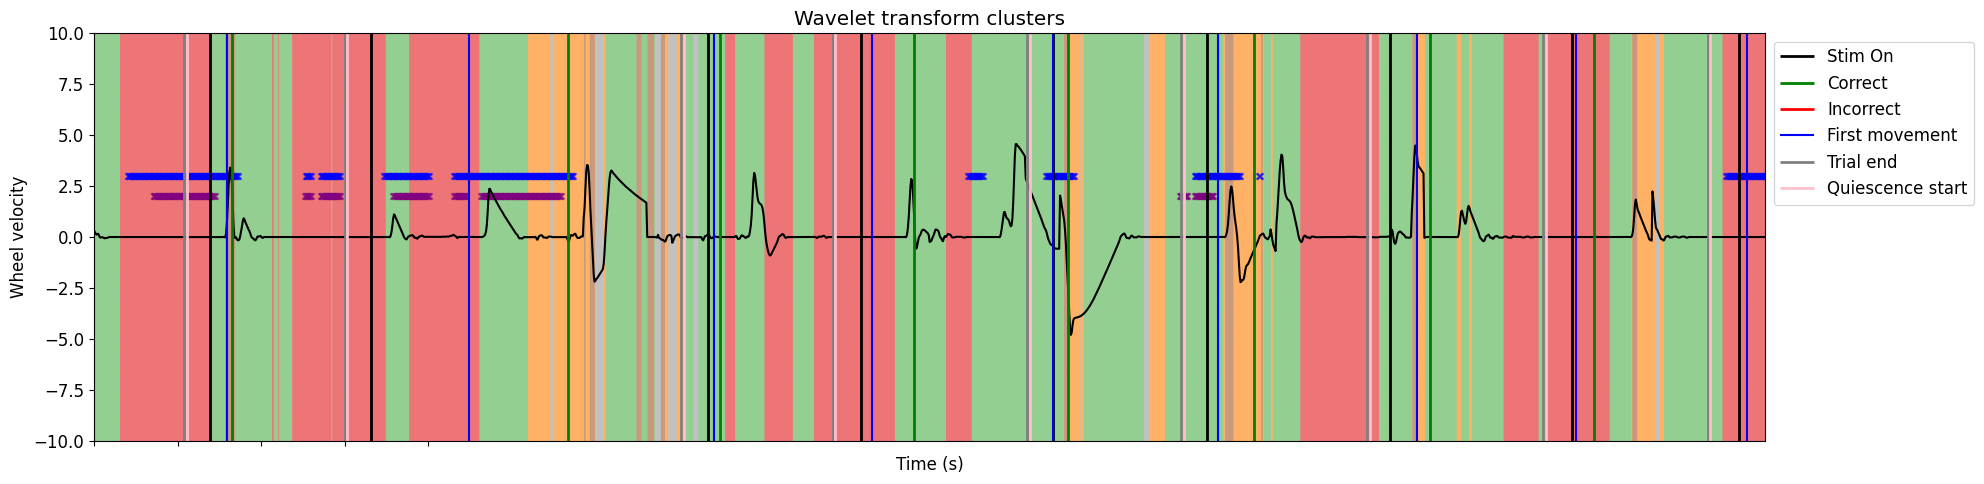

5569f363-0934-464e-9a5b-77c8e67791a1


In [18]:
# Plot raw trace over states       
init = 1500
inter = 500
use_states = 'paw_states'
wheel_over_wavelet_clusters(init, inter, empirical_data, session_trials, use_states)
print(session)